# Machine Learning for Alzheimer's Imaging
## Final Capstone Project - FullStack Academy Spring 2025 ML Cohort
### AKA AI Being Used to _Treat_ Critical Thinking Problems in the Elderly, Instead of Just Causing Them in the Young
### Author Dan McKay - June 2025


## Exploratory Sandbox File

In [ ]:
# Code Goes Here
# Initial Imports

import pandas as pd
import numpy as np

# import parquet reader
import pyarrow as pa
import pyarrow.parquet as pq

# basic graphing libraries
import seaborn as sns
import matplotlib.pyplot as plt

# import image processing libraries
import skimage
from skimage import io, transform
from PIL import Image
import io
import random

from io import BytesIO
import os
from datetime import datetime
from zoneinfo import ZoneInfo
import tensorflow as tf

#### Seed Block

In [ ]:
# There's no comment in my head at the moment that would be remotely appropriate.
SEED = 42  # For SFW meme value.

# Set seeds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Google CoLab upload block
* Add Parquet files here

In [ ]:
# Advanced propietary data file injection is one of many unique features of Google CoLab
# Okay, now that I've adverised having to upload the same external files every damn session as a positive thing, would I make a good boomer?
from google.colab import files
uploaded = files.upload()

Saving Alzheimers_Test_Dataset.parquet to Alzheimers_Test_Dataset (5).parquet
Saving Alzheimers_Train_Dataset.parquet to Alzheimers_Train_Dataset (5).parquet


## File Reading and Initial Extraction
Gonna be real, when I was writing this part, PARQUET files just seemed like a form of hate with extra steps.

In [ ]:
# Read the parquet file "Alzheimers_Train_Dataset.parquet"
df000 = pd.read_parquet("Alzheimers_Train_Dataset.parquet", engine='pyarrow')
# Print the shape of the DataFrame
print("Shape of the DataFrame:", df000.shape)
# Print the first 5 rows of the DataFrame
# print("First 5 rows of the DataFrame:")
# print(df000.head())






Shape of the DataFrame: (5120, 2)


#### Utility Block

In [109]:
# Utility Block

print(tf.keras.losses.SparseCategoricalCrossentropy)
# Date Time Utility Test

print("\n")
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
print(f"Model succesfully saved at [{now_pacific.strftime('%Y-%m-%d %H:%M:%S')}].")

print("\n")
print(df000.columns)
print(df000.iloc[0])
print(type(df000.iloc[0]['image']))


# Show my the tensorflow version
print("\nTensorFlow version:", tf.__version__)

# Confirming local temporary files tbat CoLab will erase so that I can spend more of my paid subscription uploading them again.
print("\n")
# os.listdir()


<class 'keras.src.losses.losses.SparseCategoricalCrossentropy'>


Model succesfully saved at [2025-07-01 08:11:15].


Index(['image', 'label'], dtype='object')
image    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
label                                                    2
Name: 0, dtype: object
<class 'dict'>

TensorFlow version: 2.18.0




### Image Display Testing

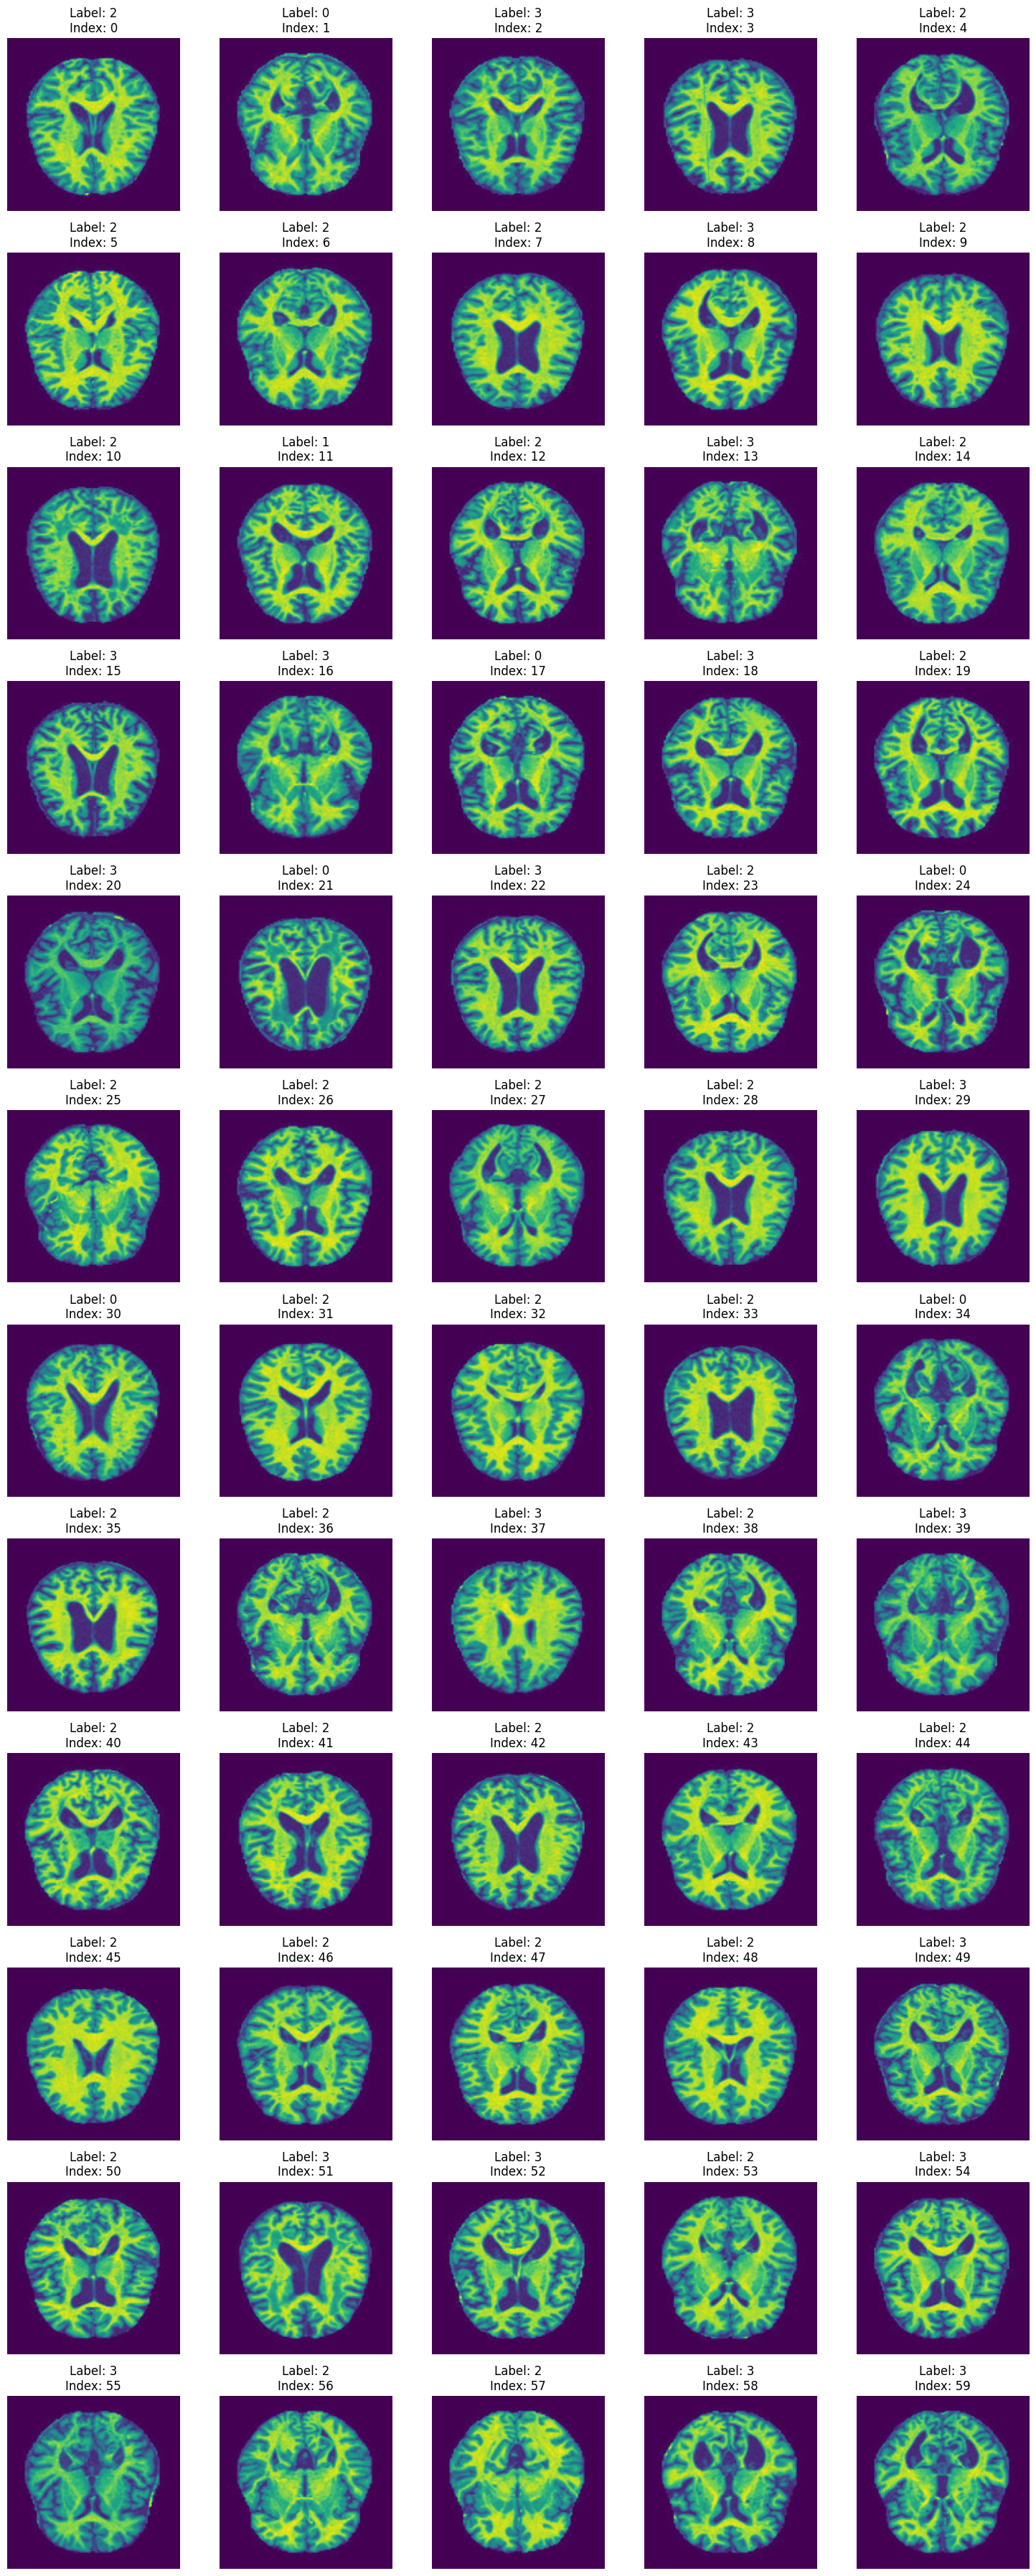

In [ ]:
# Exploratory function to decode and dispaly one image
def decode_image_from_dict(image_dict):
    image_bytes = image_dict["bytes"]
    return Image.open(BytesIO(image_bytes))


# Please display the first 5 images in a single row with their labels, as well as what number they are in the dataset.
def display_images_with_labels(df, num_images=5, img_size=(128, 128)):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        img = decode_image_from_dict(df.loc[i, 'image'])
        img = img.resize(img_size)  # Resize the image to 128x128
        label = df.loc[i, 'label']

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}\nIndex: {i}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Now, make a function to make a linebreak every 5 images, so that we can see the first 50 images in a grid format.
# It became 10 in the final submission because I got tired of scrolling past it to get to the actual training part.

def display_images_grid(df, num_images=50, img_size=(128, 128), images_per_row=5):
    num_rows = (num_images + images_per_row - 1) // images_per_row  # Calculate number of rows needed
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, num_rows * 3))

    for i in range(num_images):
        img = decode_image_from_dict(df.loc[i, 'image'])
        img = img.resize(img_size)  # Resize the image to 128x128
        label = df.loc[i, 'label']

        ax = axes[i // images_per_row, i % images_per_row]
        ax.imshow(img)
        ax.set_title(f"Label: {label}\nIndex: {i}")
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_images, num_rows * images_per_row):
        axes[j // images_per_row, j % images_per_row].axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 10 images in a grid format
display_images_grid(df000, num_images=60, img_size=(128, 128), images_per_row=5)



In [ ]:
# Just using the label column, please return the totals of each value in the label column
label_counts = df000['label'].value_counts()
# Print the label counts
print("Label counts:")
print(label_counts)

# Now, make a copy of df000 and call it df001. This doubles as a new restart point.
df001 = df000.copy()

Label counts:
label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64


### Attempted Label Organizing
The keyword is "Attempted"

In [ ]:
# Change the label column to a categorical type
df001['label'] = df001['label'].astype('category')
# Change the labels to the string values
df001['label'] = df001['label'].cat.rename_categories({
    0: 'Mild Demented',
    1: 'Moderate Demented',
    2: 'Non Demented',
    3: 'Very Mild Demented'
})

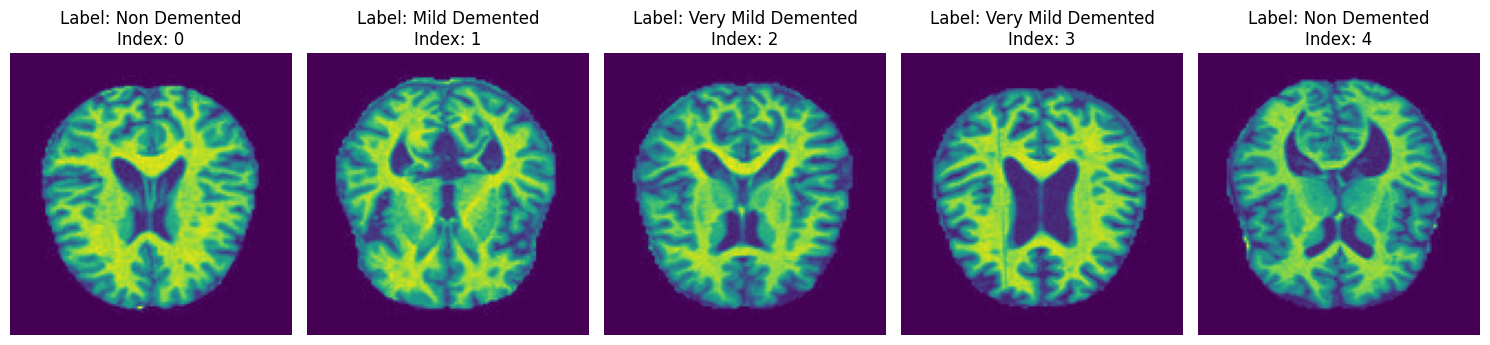

In [ ]:
# Display the first 5 images with their labels
display_images_with_labels(df001, num_images=5, img_size=(128, 128))

In [ ]:
# Now, lets change them back to integers, however make them so that Non Demented is 0, Mild Demented is 1, Very Mild Demented is 2, and Moderate Demented is 3
df001['label'] = df001['label'].cat.rename_categories({
    'Non Demented': 0,
    'Very Mild Demented': 1,
    'Mild Demented': 2,
    'Moderate Demented': 3
})


### Label Confirmation
My OCD grows ever stronger.

In [ ]:
# Now print all the values in the label column
print("Label column values after renaming:")
print(df001['label'].unique())
# Now print the label counts again
label_counts = df001['label'].value_counts()

# Now print the datatypes of each column.
print("Label counts after renaming:")
print(label_counts)


Label column values after renaming:
[0, 2, 1, 3]
Categories (4, int64): [2, 3, 0, 1]
Label counts after renaming:
label
0    2566
1    1781
2     724
3      49
Name: count, dtype: int64


#### Forced Data Conversion to Integers

In [ ]:
# Now forcibly convert the label column to an integer type

df001['label'] = df001['label'].astype(int)
# Print the datatypes of each column
print("Data types of each column:")
print(df001.dtypes)

Data types of each column:
image    object
label     int64
dtype: object


## Test Dataset Wrangling

In [ ]:
# Reorganizing the testing dataset as well
# Read the parquet file "Alzheimers_Test_Dataset.parquet"
dftest000 = pd.read_parquet("Alzheimers_Test_Dataset.parquet", engine='pyarrow')


Shape of the test DataFrame: (1280, 2)

Also, this is from the TEST dataset:



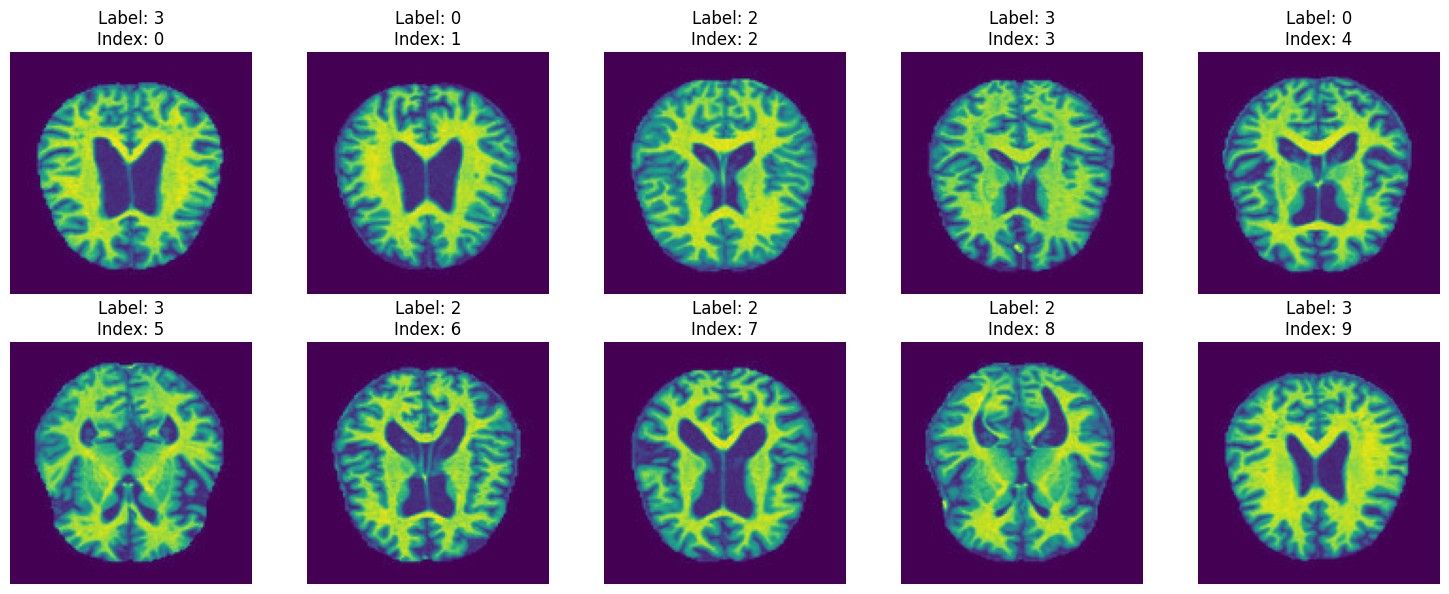

In [ ]:
# Display the first 50 images in a grid format
print("Shape of the test DataFrame:", dftest000.shape)
print("\nAlso, this is from the TEST dataset:\n")
display_images_grid(dftest000, num_images=10, img_size=(128, 128), images_per_row=5)
# It's crazy how many of these look like weird luchador masks

In [ ]:
# Just using the label column, please return the totals of each value in the label column
label_counts = dftest000['label'].value_counts()
# Print the label counts
print("Label counts:")
print(label_counts)
# Now, make a copy of df000 and call it df001
dftest001 = dftest000.copy()

Label counts:
label
2    634
3    459
0    172
1     15
Name: count, dtype: int64


### Image Labeling
This is temporary.

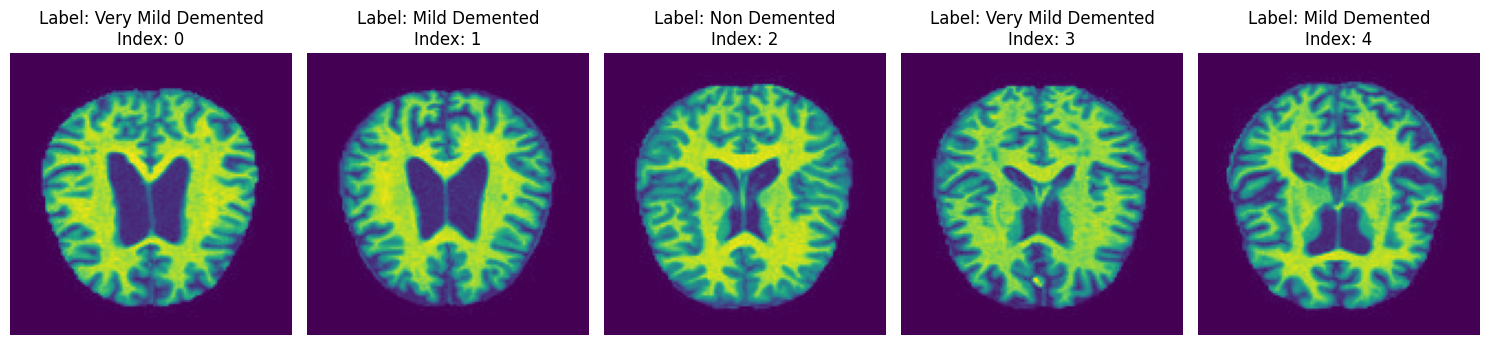

In [ ]:
# Change the label column to a categorical type
dftest001['label'] = dftest001['label'].astype('category')
# Change the labels to the string values
dftest001['label'] = dftest001['label'].cat.rename_categories({
    0: 'Mild Demented',
    1: 'Moderate Demented',
    2: 'Non Demented',
    3: 'Very Mild Demented'
})

# Display the first 5 images with their labels
display_images_with_labels(dftest001, num_images=5, img_size=(128, 128))


### Image Un-labeling
Told you :P

In [ ]:
dftest001['label'] = dftest001['label'].cat.rename_categories({
    'Non Demented': 0,
    'Very Mild Demented': 1,
    'Mild Demented': 2,
    'Moderate Demented': 3
})


In [ ]:
# Now print all the values in the label column
print("Label column values after renaming:")
print(dftest001['label'].unique())
# Now print the label counts again
label_counts = dftest001['label'].value_counts()
# Now print the datatypes of each column
print("Label counts after renaming:")
print(label_counts)


Label column values after renaming:
[1, 2, 0, 3]
Categories (4, int64): [2, 3, 0, 1]
Label counts after renaming:
label
0    634
1    459
2    172
3     15
Name: count, dtype: int64


### Forced Integer Classification. Again.
It's very important that everyone's brain has a proper number attached.

For The Harvest.

In [ ]:
# Force the 'label' column to be an integer type with a sledgehammer plz k thnx bye
dftest001['label'] = dftest001['label'].astype(int)
# Print the datatypes of each column
print("Data types of each column:")
print(dftest001.dtypes)

Data types of each column:
image    object
label     int64
dtype: object


## LOTS MOAR IMPROTS!!!!
It's like making sausage: ya don't wanna know.

In [ ]:
# Some image analysis imports
import tensorflow as tf
from tensorflow.keras import layers, Input, models, Model # type: ignore
from tensorflow.keras.models import Sequential, load_model  # type: ignore
from tensorflow.keras.layers import ( # type: ignore
     Dense, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, MaxPooling2D)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping  # type: ignore
from tensorflow.keras.layers import ( # type: ignore
    GlobalMaxPooling2D, Concatenate,
    Dense, Dropout, BatchNormalization, Activation, Lambda,
    RandomFlip, RandomRotation, RandomZoom, GaussianNoise
) # type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # type: ignore
from tensorflow.keras.applications import DenseNet201 # type: ignore
import tensorflow.keras.backend as K # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore

# from tensorflow.keras.applications import EfficientNetB0  # type: ignore
# from tensorflow.keras.applications import DenseNet121, DenseNet169 # type: ignore
# from tensorflow.keras.losses import CategoricalCrossentropy # type: ignore
# import tensorflow.keras.losses as losses
# from tensorflow.keras.preprocessing.image import ImageDataGenerator  # type: ignore


In [ ]:
# Non-TF additional add-ons
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report



### Dataframe Copy

In [ ]:
# Now, make a copy of df001
df002 = df001.copy()

### Initial Train Test Split

In [ ]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df002, test_size=0.2, random_state=42, stratify=df001['label'])

# NumPy conversion

def decode_image_bytes(img_obj):
    image_bytes = img_obj['bytes']  # ✅ Extract the actual bytes
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")  # Ensure 3 channels
    image = image.resize((128, 128))
    return np.array(image) / 255.0  # Normalize to [0, 1]

# Apply decoding
images_np = np.stack(df001['image'].apply(decode_image_bytes))
labels_np = df001['label'].values

# Step 2: Split data
X_train, X_test, y_train, y_test = train_test_split(
    images_np, labels_np, test_size=0.2, random_state=42, stratify=labels_np
)

# Step 3: Convert to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(4096).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# The Actual Training Model

### Custom Distortion Functions
#### Custom Squish + Gaussian Blur

Younger me would have probably used this part as a dream journal too.

<sub>My paralysis demon told me to buy bitcoin again I don't deserve this ;__;</sub>





In [ ]:
# Blur function
def random_blur(image, blur_chance=0.3, ksize=(3, 3), sigma=0.4):
    def _blur_fn(img):
        if np.random.rand() < blur_chance:
            img = img.numpy()
            blurred = cv2.GaussianBlur(img, ksize, sigmaX=sigma)
            return blurred.astype(np.float32)
        return img.numpy().astype(np.float32)

    blurred_img = tf.py_function(_blur_fn, [image], tf.float32)
    blurred_img.set_shape(image.shape)  # 👈 VERY important!
    return blurred_img

def random_squish(image):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Choose a random scale, preferably between 0.9 and 1.1.
    # I am not always the preferable type.
    width_scale = tf.random.uniform([], 0.975, 1.025)
    height_scale = tf.random.uniform([], 0.975, 1.025)

    new_height = tf.cast(tf.cast(height, tf.float32) * height_scale, tf.int32)
    new_width = tf.cast(tf.cast(width, tf.float32) * width_scale, tf.int32)

    squished = tf.image.resize(image, [new_height, new_width])
    return tf.image.resize(squished, [height, width])  # restore to original size

squish_layer = Lambda(random_squish)

# Time Stamp
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
print(f"Squish function parameters updated at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")

Squish function parameters updated at 06:17:12 AM on July 01, 2025 Pacific Time ⏰


## Data Augmentation Function
Distortion Max Ultra!

In [ ]:
# Compiled Data Augmentation for image randomization and small errors
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.GaussianNoise(0.01),
    # Lambda(lambda x: random_blur(x, blur_chance=0.25, ksize=(3,3), sigma=0.4)),
    Lambda(random_squish), # custom squishing
], name="data_augmentation")

# Time Stamp
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
print(f"Data Augmentation parameters updated at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")

Data Augmentation parameters updated at 06:17:14 AM on July 01, 2025 Pacific Time ⏰


### Separated Utility Code for Compiler Injection - Yes that is a real description and not just mockery
#### Class Weights, Callbacks, and Test/Train Split Batching & Shuffle


In [ ]:
# Class Weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(np.clip(class_weights, 1.0, 22.0)))  # Clip weights to set range, even if it's a ridiculous one

# class_weights = dict(enumerate(class_weights)) # Uncapped version

# Callback Definitions

model_checkpoint = ModelCheckpoint(
    'best_densenet_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=6e-8,
    mode='min'
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=9,
    restore_best_weights=True
)

# # Commented out when Oversample block is in effect, even if toggled to False
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(4096).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)


# Time Stamp
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
print(f"DualPool Model utility parameters updated at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")

DualPool Model utility parameters updated at 07:00:18 AM on July 01, 2025 Pacific Time ⏰


# DualPool DenseNet~~121~~ ~~169~~ ~~201?~~ ~~169??~~ no definitely 201 Model Compile
### GlobalAveragePooling + GlobalMaxPooling2D:
### Creating an unholy chimera that meddles with God's design

Serial Build Compilation



In [ ]:
# Creating the DenseNet201 base model with DualPool averaging

# Base model
base_model = DenseNet201(
    include_top=False,
    input_shape=(128, 128, 3),
    weights='imagenet')

base_model.trainable = True

# Input layer
inputs = Input(shape=(128, 128, 3))

# Randomly distorting pictures to reduce overfitting
x = data_augmentation(inputs)  # comment out if Oversample block is in effect, even if toggled to False

# Pass through base model
x = base_model(inputs, training=True)

# Freeze all but last whatever it says layers
for layer in base_model.layers[:-115]:
    layer.trainable = False

# Dual Pooling
avg_pool = GlobalAveragePooling2D()(x)
max_pool = GlobalMaxPooling2D()(x)
pooled = Concatenate()([avg_pool, max_pool])  # shape: (None, 2048)

# Serial style aggregation of layers

# Classifier head (deeper than before)
x = Dense(64, kernel_regularizer=l2(2e-4))(pooled) # L2 Regularization enabled
x = BatchNormalization()(x)                           # Pass the output of Dense to BatchNormalization
x = Activation('relu')(x)                             # Pass the output of BatchNormalization to Activation
x = Dropout(0.575)(x)                                  # Pass the output of Activation to Dropout

# x = Dropout(0.6)(x)                                  # Aka a prayer to RNGesus for a lucky change near plateau, kept low to not otherwise interfere

# # For extra scrutiny. My model apparently benefits from eye glasses like most any other nerd.
# x = Dense(32, kernel_regularizer=l2(4e-5))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.4)(x)

# # Experimental third Dense Layer that will probably backfire
# x = Dense(32, kernel_regularizer=l2(4e-5))(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.25)(x)

# Output
outputs = Dense(4, activation='softmax')(x)

# Final model
dualpool_model = Model(inputs=inputs, outputs=outputs)

# Compilation
dualpool_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=7.5e-6), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

# Time stamps are really helpful for telling me I've overwritten something valuable and should punch myself.
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
print(f"Dual Pool Model defined and compiled at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰\n")

# Summary
# dualpool_model.summary()

Dual Pool Model defined and compiled at 07:00:25 AM on July 01, 2025 Pacific Time ⏰



# MANUAL HARD BREAK POINT

In [ ]:
# Insertable Stopping Point
# raise SystemExit("🛑 Manual checkpoint: stopping execution here.") # Comment out when not in use
print("Clear Cell")

Clear Cell


## DualPool Loading Block

In [ ]:
# Time Stamp variable
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))

# Loading the DenseNet201 model if it exists
try:
    if os.path.exists('best_dualpool201_model.keras'):
        dualpool_model = load_model('best_dualpool201_model.keras')
        print(f"✅ DualPool model loaded successfully at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")
    else:
        raise FileNotFoundError("Model file 'best_dualpool201_model.keras' not found, training from scratch.")
except FileNotFoundError as e:
    print(f"❌ {e}")
except Exception as e:
    print(f"⚠️ Failed to load DualPool model: {type(e).__name__} - {e}")
# print("Clear Cell")

# DualPool Training Block

The best reason to play videogames since CoVID

In [ ]:
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
# Dual Pool Training Block

print(f"Training starting at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰\n")

# Here is the training part. The part that lets me play videogames while being productive.
densenet_history = dualpool_model.fit(
    train_ds, # Use the original train_ds with integer labels
    validation_data=test_ds, # Use the original test_ds with integer labels
    epochs=150, # Reduced epochs for quicker testing
    class_weight=class_weights,
    callbacks=[model_checkpoint, reduce_lr, early_stop]
)

# Early Stoppage printed note. The model hasn't crashed, it's just become afraid of brain damage.
epochs_ran = len(densenet_history.history['loss'])
if epochs_ran < 150:
    print(f"\nTraining stopped early after {epochs_ran} epochs due to EarlyStopping at {now_pacific.strftime('%I:%M:%S %p')} ⏰")
else:
    print(f"\nTraining completed all 150 epochs at {now_pacific.strftime('%I:%M:%S %p')} ⏰")

Training starting at 07:00:29 AM on July 01, 2025 Pacific Time ⏰

Epoch 1/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 104s 212ms/step - accuracy: 0.2193 - loss: 2.6284 - val_accuracy: 0.2773 - val_loss: 1.5083 - learning_rate: 7.5000e-06
Epoch 2/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.2721 - loss: 2.2370 - val_accuracy: 0.3418 - val_loss: 1.3975 - learning_rate: 7.5000e-06
Epoch 3/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.3018 - loss: 2.0414 - val_accuracy: 0.4033 - val_loss: 1.3311 - learning_rate: 7.5000e-06
Epoch 4/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.3530 - loss: 1.9200 - val_accuracy: 0.4521 - val_loss: 1.2895 - learning_rate: 7.5000e-06
Epoch 5/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.3642 - loss: 1.8023 - val_accuracy: 0.4756 - val_loss: 1.2495 - learning_rate: 7.5000e-06
Epoch 6/150
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.3966 - loss: 1.7018 - val_accuracy: 0.5068 - val_loss: 1.1992 - learning_

## DualPool Evaluation and Saving

In [ ]:
# Dual Pool Evaluation

test_loss, test_accuracy = dualpool_model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Validation Loss: {densenet_history.history['val_loss'][-1]:.4f}, Validation Accuracy: {densenet_history.history['val_accuracy'][-1]:.4f}")
print(f"Testing done at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9568 - loss: 0.1565
Test Loss: 0.1639, Test Accuracy: 0.9600
Validation Loss: 0.1644, Validation Accuracy: 0.9590
Testing done at 07:00:29 AM on July 01, 2025 Pacific Time ⏰


In [ ]:
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
# Dual Pool Saving

dualpool_model.save("best_dualpool201_model.keras")
print(f"💾 DualPool model saved as 'best_dualpool201_model.keras at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")

💾 DualPool model saved as 'best_dualpool201_model.keras at 07:17:28 AM on July 01, 2025 Pacific Time ⏰


### DualPool Offline Saving

In [ ]:
# Download DualPool file
from google.colab import files
files.download('best_dualpool201_model.keras')

# Time Stamp
now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
print(f"💾 DualPool model downloaded at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

💾 DualPool model downloaded at 07:17:47 AM on July 01, 2025 Pacific Time ⏰


## DualPool F1 Evaluation

In [ ]:
#F1 Scores

# 1. Get predictions from model
y_pred_probs = dualpool_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Get true labels from test_ds
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 3. Compute F1 scores
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# 4. Switch the orders for index 1 and 2
# This swaps class 1 (Mild) and class 2 (Very Mild)
new_order = [0, 1, 2, 3]
y_pred = np.array([new_order[i] for i in y_pred])
y_true = np.array([new_order[i] for i in y_true])


# 5. Print the F1 Scores
print(f"\n📊 F1 Macro Score: {f1_macro:.4f}")
print(f"📊 F1 Weighted Score: {f1_weighted:.4f}")

# Optional: Full classification report
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=[
    "Non-Demented", "Very Mild", "Mild", "Moderate"
    ]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step

📊 F1 Macro Score: 0.9596
📊 F1 Weighted Score: 0.9599

📋 Classification Report:
              precision    recall  f1-score   support

Non-Demented       0.96      0.96      0.96       513
   Very Mild       0.96      0.94      0.95       356
        Mild       0.97      0.98      0.97       145
    Moderate       0.91      1.00      0.95        10

    accuracy                           0.96      1024
   macro avg       0.95      0.97      0.96      1024
weighted avg       0.96      0.96      0.96      1024



## Densenet DualPool Confusion Matrix

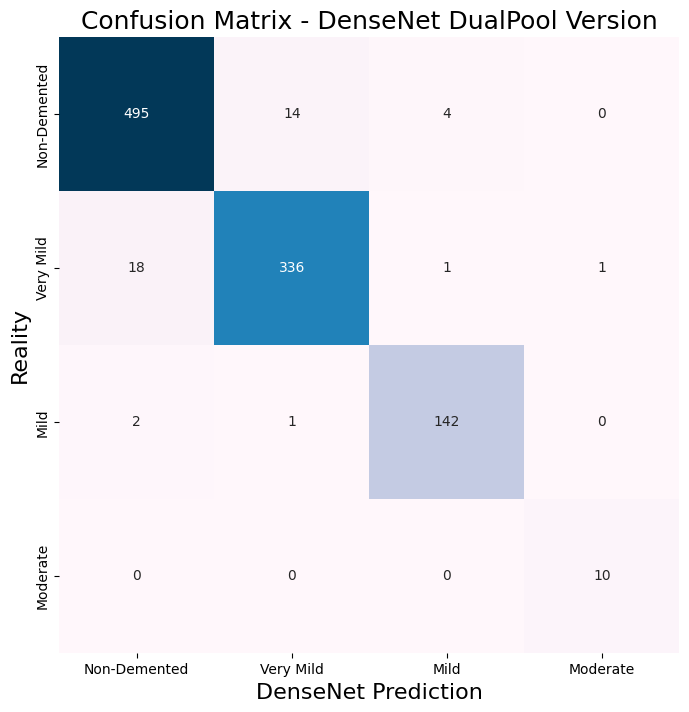

In [ ]:
# 1. Recompute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Order confirmation
order = [0, 1, 2, 3] # Somehow, I have to make sure this doesn't get scrambled. Because my dementia detecting code has dementia >:|
cm_display = cm[np.ix_(order, order)]

# 3. Plot heatmap with names unchanged
plt.figure(figsize=(8, 8))
sns.heatmap(cm_display, annot=True, fmt='d', cmap='PuBu', cbar=False,
            xticklabels=["Non-Demented", "Very Mild", "Mild", "Moderate"],
            yticklabels=["Non-Demented", "Very Mild", "Mild", "Moderate"])
plt.xlabel("DenseNet Prediction", fontsize=16)
plt.ylabel("Reality", fontsize=16)
plt.title("Confusion Matrix - DenseNet DualPool Version", fontsize=18)
# plt.tight_layout()
plt.show()

## Additional Upload Block
* Use to load images in Google CoLab

In [ ]:
# Sometimes I just don't wanna scroll all the way to the top >_>
from google.colab import files
uploaded = files.upload()

# Image Prediction Function
#### This is the one that matters
Instructions for now:
* Place an image with the same name in the same directory, and name it "test01.png"
* Alternately just upload it with the code block above this in Google CoLab
* Run this block. It should give both a prediction and a Confidence rating.

In [101]:
# Define class names for output
def predict_training_images(indices, X_data, y_data, class_names, max_images=5):
    try:
        if not isinstance(indices, (list, tuple)):
            raise ValueError("Please provide a list or tuple of indices.")
        if len(indices) > max_images:
            raise ValueError(f"You can only predict up to {max_images} images at once.")

        n = len(indices)
        plt.figure(figsize=(n * 3, 4))

        for i, index in enumerate(indices):
            if index < 0 or index >= len(X_data):
                print(f"⚠️ Skipping invalid index: {index}")
                continue

            image = X_data[index]
            true_label = class_names[y_data[index]]

            input_tensor = np.expand_dims(image, axis=0)
            prediction = dualpool_model.predict(input_tensor, verbose=0)[0]

            top_idx = np.argmax(prediction)
            top_conf = prediction[top_idx]
            top_label = class_names[top_idx]

            # Find second most likely class
            second_idx = np.argsort(prediction)[-2]
            second_label = class_names[second_idx]
            second_conf = prediction[second_idx]

            # Title content
            title = f"Index: {index}\n{top_label} ({top_conf:.1%})\nTrue: {true_label}"
            if top_conf < 0.85:
                title += f"\n2nd: {second_label} ({second_conf:.1%})"

            # Display
            plt.subplot(1, n, i + 1)
            plt.imshow(image)
            plt.axis('off')
            plt.title(title, fontsize=9)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error: {e}")



## Image Prediction Run Block
#### (Okay THIS is the one that matters, but you need to run the cell above first)

⚠️ File not found: test08.png
⚠️ File not found: test09.png
⚠️ File not found: test10.png


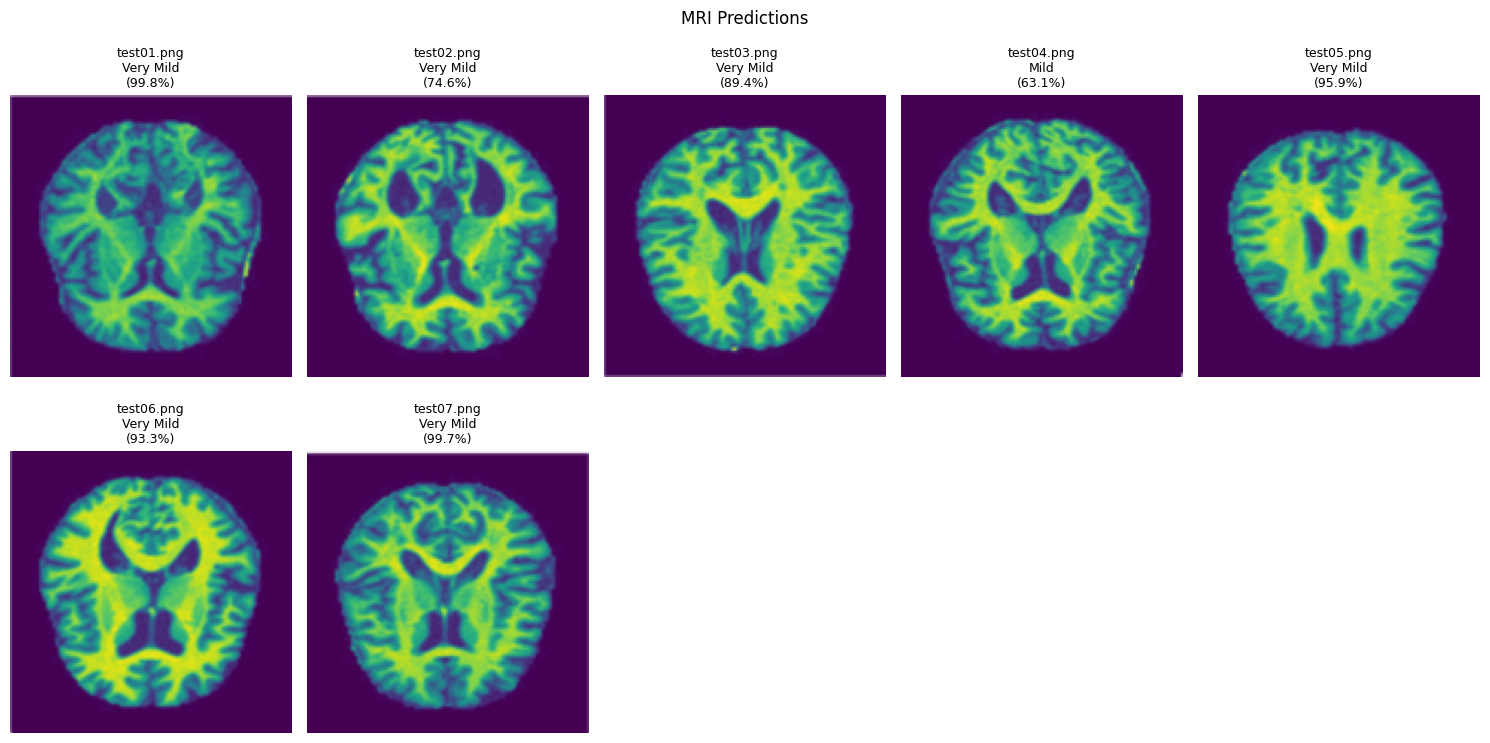

In [85]:
# Gonna keep this simple for now
predict_mri_batch() # type: ignore


## Image Reset Block
This is just to dump the images currently uploaded specifically for predictions.

In [ ]:
def clear_mri_predictions():
    global images, predictions, filenames
    images = []
    predictions = []
    filenames = []
    print("🧹 Cleared stored images and predictions from memory.")


In [ ]:
# Actual Function separated into a separate block
clear_mri_predictions()


### Google CoLab Image Deletion
Specific to Google CoLab

In [ ]:
for i in range(1, 11):
    file_path = f"test{str(i).zfill(2)}.png"
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"🗑️ Deleted {file_path}")
    else:
        print(f"⚠️ Not found: {file_path}")


## ~~Sanity Test~~ Direct Accuracy Sample Test
Running the first X images in the testing set against the Prediction Function

In [115]:
def predict_test_batch(X_test, y_test, count=60):
    predictions = []
    true_labels = []

    for i in range(min(count, len(X_test))):
        image = np.expand_dims(X_test[i], axis=0)  # Add batch dimension
        pred = dualpool_model.predict(image, verbose=0)
        pred_class = np.argmax(pred[0])
        confidence = pred[0][pred_class]

        predictions.append((class_names[pred_class], confidence))
        true_labels.append(class_names[y_test[i]])

    # Combine into a clean table format
    for i, (pred, true) in enumerate(zip(predictions, true_labels)):
        label, conf = pred
        print(f"🧠 Image {i+1:02}: Predicted → {label:<14} ({conf:.1%}) | True → {true}")

    return predictions, true_labels

# Function execution
preds, truths = predict_test_batch(X_test, y_test)
# test


🧠 Image 01: Predicted → Very Mild      (99.3%) | True → Very Mild
🧠 Image 02: Predicted → Non-Demented   (92.8%) | True → Non-Demented
🧠 Image 03: Predicted → Very Mild      (98.5%) | True → Very Mild
🧠 Image 04: Predicted → Very Mild      (99.5%) | True → Very Mild
🧠 Image 05: Predicted → Very Mild      (99.1%) | True → Very Mild
🧠 Image 06: Predicted → Non-Demented   (99.0%) | True → Non-Demented
🧠 Image 07: Predicted → Non-Demented   (73.8%) | True → Non-Demented
🧠 Image 08: Predicted → Very Mild      (98.7%) | True → Very Mild
🧠 Image 09: Predicted → Very Mild      (95.5%) | True → Very Mild
🧠 Image 10: Predicted → Mild           (99.9%) | True → Mild
🧠 Image 11: Predicted → Non-Demented   (99.2%) | True → Non-Demented
🧠 Image 12: Predicted → Non-Demented   (99.3%) | True → Non-Demented
🧠 Image 13: Predicted → Very Mild      (97.7%) | True → Very Mild
🧠 Image 14: Predicted → Non-Demented   (99.5%) | True → Non-Demented
🧠 Image 15: Predicted → Non-Demented   (99.5%) | True → Non-Dem

### Specific Training Image Predictor
* Select specific images from the testing set as entered by index number in the latter code block
* Maximum of 5 at a time right now, but this can be easily changed.

In [140]:
# Specified Image Prediction Function from Testing Set
# Set maximum number of images specified directly below
def predict_testing_images(indices, X_data, y_data, class_names, max_images=5):
    try:
        if not isinstance(indices, (list, tuple)):
            raise ValueError("Please provide a list or tuple of indices.")
        if len(indices) > max_images:
            raise ValueError(f"You can only predict up to {max_images} images at once.")

        # Convert from 1-based to 0-based
        indices = [i - 1 for i in indices]

        n = len(indices)
        plt.figure(figsize=(n * 3, 4))

        for i, index in enumerate(indices):
            adjusted_index = index + 1  # Displayed index (1-based)

            if index < 0 or index >= len(X_data):
                print(f"⚠️ Skipping invalid index: {adjusted_index} (out of bounds)")
                continue

            image = X_data[index]
            true_label = class_names[y_data[index]]

            input_tensor = np.expand_dims(image, axis=0)
            prediction = dualpool_model.predict(input_tensor, verbose=0)[0]

            top_idx = np.argmax(prediction)
            top_conf = prediction[top_idx]
            top_label = class_names[top_idx]

            # Second-best prediction
            second_idx = np.argsort(prediction)[-2]
            second_label = class_names[second_idx]
            second_conf = prediction[second_idx]

            # Title formatting
            title = (
                f"Image #{adjusted_index}\n"
                f"{top_label} ({top_conf:.1%})\n"
                f"True: {true_label}"
            )
            if top_conf < 0.85:
                title += f"\n2nd Most Likely: {second_label} ({second_conf:.1%})"

            plt.subplot(1, n, i + 1)
            plt.imshow(image)
            plt.axis('off')
            plt.title(title, fontsize=9)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error: {e}")





now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
print(f"Function last run at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")

Function last run at 08:32:17 AM on July 01, 2025 Pacific Time ⏰


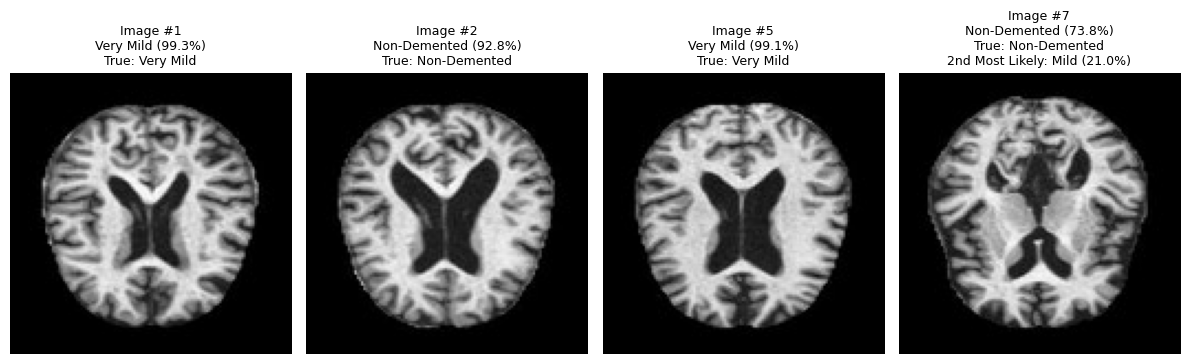

In [141]:
# Code Execute
predict_testing_images([1,2, 5, 7], X_test, y_test, class_names)



## Frivolous VS Code Styling Block
I can make things so pretty!

I can also brick a Jupyter notebook with this if inclined.... I really wish I hadn't learned about the second one...

In [ ]:
%%html
<style>* {   color: aquamarine;
# background-color: SpringGreen;
# padding: 5px;

 !important;}</style>

# Oversample Function and Dataset Pre-definition Block
#### And other ways to horribly sabotage your own code
<sub> Note: I wanted to keep this albatross of a code block just to show I tried it, and it technically works if you move it to after initial Data Augmentation, but since it doesn't help accuracy at all, it has now been commented out and moved to the bottom to make the rest of the code more readable. </sub>

In [82]:
# # Toggle oversampling ON or OFF
# # All caps, because I really need to glance at this thing now and then for safety reasons

# ENABLE_OVERSAMPLING = False

# # Set class targets (based on your 8192 or 6656 total and GPU limits)


# desired_totals = {
#     0: 2048,  # non-demented (no change)
#     1: 1784,  # very mild dementia
#     2: 1088,  # mild dementia
#     3: 200   # moderate dementia
# }

# # desired_totals = {
# #     0: 2048,  # non-demented (yes, this is discarding some images)
# #     1: 2048,  # very mild dementia
# #     2: 2048,  # mild dementia
# #     3: 2048   # moderate dementia
# # }


# # Function to oversample or randomly undersample to a specific target
# def oversample_class_to_target(X, y, class_label, target_count):
#     class_indices = np.where(y == class_label)[0]
#     X_class = X[class_indices]
#     y_class = y[class_indices]

#     if target_count > len(X_class):
#         # Oversample
#         reps = int(np.ceil(target_count / len(X_class)))
#         X_aug = np.tile(X_class, (reps, 1, 1, 1))[:target_count]
#         y_aug = np.tile(y_class, reps)[:target_count]
#     else:
#         # Undersample randomly
#         idx = np.random.choice(len(X_class), target_count, replace=False)
#         X_aug = X_class[idx]
#         y_aug = y_class[idx]

#     ds = tf.data.Dataset.from_tensor_slices((X_aug, y_aug))
#     ds = ds.shuffle(2048).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
#     return ds

# # Build dataset
# if ENABLE_OVERSAMPLING:
#     print("📈 Oversampling enabled with class targets:", desired_totals)
#     balanced_datasets = [
#         oversample_class_to_target(X_train, y_train, class_label, desired_totals[class_label])
#         for class_label in desired_totals
#     ]
#     train_ds = balanced_datasets[0]
#     for ds in balanced_datasets[1:]:
#         train_ds = train_ds.concatenate(ds)
#         # ds = ds.shuffle(2048).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
#         ds = ds.shuffle(2048).map(lambda x, y: (data_augmentation(x), y))  # Removed AUTOTUNE

#     train_ds = train_ds.shuffle(4096).batch(32).prefetch(1)
# else:
#     print("📊 Using regular training dataset.")
#     train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#     train_ds = train_ds.shuffle(4096).map(lambda x, y: (data_augmentation(x), y))
#     # train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
#     train_ds = train_ds.shuffle(6656).batch(32).prefetch(1)  # Removed AUTOTUNE



# # Time Stamp
# from datetime import datetime
# from zoneinfo import ZoneInfo
# now_pacific = datetime.now(ZoneInfo("America/Los_Angeles"))
# print(f"Oversample function updated at {now_pacific.strftime('%I:%M:%S %p on %B %d, %Y')} Pacific Time ⏰")
print ("Clear cell")

Clear cell
